In [1]:
%env KERAS_BACKEND=tensorflow
%env CUDA_HOME=/usr/local/cuda-7.5

env: KERAS_BACKEND=tensorflow
env: CUDA_HOME=/usr/local/cuda-7.5


In [2]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage
from matplotlib import path

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_filepaths():
    with open('../../data_supp/filepaths_train.pkl', 'rb') as f:
        filepaths_train = pickle.load(f)
    with open('../../data_supp/filepaths_val.pkl', 'rb') as f:
        filepaths_val = pickle.load(f)
    return filepaths_train, filepaths_val

def get_training_labels():
    systole_labels = {}
    diastole_labels = {}
    with open('../../data/train.csv', 'r') as f:
        for _id, systole, diastole in csv.reader(f):
            if _id == 'Id':
                continue
            systole_labels[int(_id)] = float(systole)
            diastole_labels[int(_id)] = float(diastole)
    return systole_labels, diastole_labels

In [4]:
filepaths_train, filepaths_val = get_filepaths()

systole_labels, diastole_labels = get_training_labels()

In [5]:
def create_label(pt, mode='ED'):
    if mode == 'ES':
        return systole_labels[pt] < np.arange(600)
    elif mode == 'ED':
        return diastole_labels[pt] < np.arange(600)
    else:
        raise

        
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)


def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std


def crop_to_square(arr, size):
    x_len, y_len = arr.shape
    shorter_len = min(x_len, y_len)
    x_start = (arr.shape[0] - shorter_len) // 2
    x_end = x_start + shorter_len
    y_start = (arr.shape[1] - shorter_len) // 2
    y_end = y_start + shorter_len
    return transform.resize(arr[x_start:x_end, y_start:y_end], 
                            (size, size), order=1, clip=True, preserve_range=True)


def crop_to_square_normalized(img_orig, pixel_spacing, size):
    img_norm = ndimage.interpolation.zoom(img_orig, [float(x) for x in pixel_spacing], order=0, mode='constant')
    
    length_x, length_y = img_norm.shape
    if length_x >= size:
        x_start = length_x // 2 - size // 2
        x_end = length_x // 2 + size // 2
    else:
        x_start = 0
        x_end = length_x
    if length_y >= size:
        y_start = length_y // 2 - size // 2
        y_end = length_y // 2 + size // 2
    else:
        y_start = 0
        y_end = length_y
    
    img_new = np.zeros((size, size))
    new_x_shift = (size - (x_end - x_start)) // 2
    new_y_shift = (size - (y_end - y_start)) // 2
    img_new[new_x_shift:(new_x_shift + x_end - x_start), 
            new_y_shift:(new_y_shift + y_end - y_start)] = img_norm[x_start:x_end, y_start:y_end]
    
    return img_new


def localize_to_centroid(img, centroid, width_about_centroid):
    # assumes already cropped to square
    x, y = centroid
    x = int(round(x))
    y = int(round(y))
    x_start = x - width_about_centroid // 2
    x_end = x + width_about_centroid // 2
    y_start = y - width_about_centroid // 2
    y_end = y + width_about_centroid // 2
    
    if x_start < 0:
        x_end += (0 - x_start)
        x_start = 0
    if x_end > img.shape[0]:
        x_start -= (img.shape[0] - x_end)
        x_end = img.shape[0]
    if y_start < 0:
        y_end += (0 - y_start)
        y_start = 0
    if y_end > img.shape[1]:
        y_start -= (img.shape[1] - y_end)
        y_end = img.shape[1]
        
    return img[x_start:x_end, y_start:y_end], (x_start, x_end), (y_start, y_end)


def normalized_z_loc(df):
    # assumes patient position HFS
    
    position = [float(s) for s in df.ImagePositionPatient]
    orientation = [float(s) for s in df.ImageOrientationPatient]
    
    # first voxel coordinates from DICOM ImagePositionPatient field
    x_loc, y_loc, z_loc = position
    
    # row/column direction cosines from DICOM ImageOrientationPatient field
    row_dircos_x, row_dircos_y, row_dircos_z, col_dircos_x, col_dircos_y, col_dircos_z = orientation
    
    # normalized direction cosines
    dircos_x = row_dircos_y * col_dircos_z - row_dircos_z * col_dircos_y
    dircos_y = row_dircos_z * col_dircos_x - row_dircos_x * col_dircos_z
    dircos_z = row_dircos_x * col_dircos_y - row_dircos_y * col_dircos_x
    
    # z-coordinate location recalculated based on reference
    z_loc_norm = dircos_x * x_loc + dircos_y * y_loc + dircos_z * z_loc
    return z_loc_norm


def get_all_series_filepaths(filepaths):
    t_slices = 30
    
    # create sax series filepaths
    # handles irregularies such as those including z-slices and t-slices in the same folder
    series_filepaths_all = []
    for view in filepaths.keys(): 
        if not re.match(r'^sax', view):
            continue
        
        if len(filepaths[view]) == t_slices:
            series_filepaths_all.append(filepaths[view])
        elif len(filepaths[view]) < t_slices:
            series_filepaths_all.append(filepaths[view][:] + filepaths[view][:(t_slices - len(filepaths[view]))])
        else:
            if re.match(r'^\w+-\d+-\d+-\d+.dcm$', filepaths[view][0][0]) is not None:
                series_filepaths_split = []
                slices_list = []
                series_filepaths_sort_by_slice = sorted(filepaths[view][:], 
                                                        key=lambda x: '{}-{}'.format(x[0].split('-')[-1].split('.')[0], 
                                                                                     x[0].split('-')[-2]))
                for fname, fpath in series_filepaths_sort_by_slice:
                    nslice = fname.split('-')[-1].split('.')[0]
                    tframe = fname.split('-')[-2]
                    if nslice not in slices_list:
                        if len(series_filepaths_split) == t_slices:
                            series_filepaths_all.append(series_filepaths_split)
                        elif len(series_filepaths_split) < t_slices and len(series_filepaths_split) > 0:
                            series_filepaths_all.append((series_filepaths_split[:] + 
                                                         series_filepaths_split[:(t_slices - len(series_filepaths_split))]))
                        series_filepaths_split = []
                        series_filepaths_split.append((fname, fpath))
                        slices_list.append(nslice)
                    else:
                        series_filepaths_split.append((fname, fpath))
                        
    return series_filepaths_all

### ES frames

In [6]:
with open('../../data_supp/pt_es_frame.pkl', 'rb') as f:
    pt_es_frame = pickle.load(f)

### Initialize neural nets

In [7]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializations
from keras.layers.core import Layer
from keras import backend as K
import tensorflow as tf

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=None, keepdims=False))

def binaryCE(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=None, keepdims=False)

class Rotate90(Layer):
    def __init__(self, direction='clockwise', mode='tf', **kwargs):
        super(Rotate90, self).__init__(**kwargs)
        self.direction = direction
        self.mode = mode

    def get_output(self, train):
        X = self.get_input(train)
        if self.direction == 'clockwise':
            if self.mode == 'tf':
                return tf.reverse(tf.transpose(X, perm=[0, 2, 1]), dims=[False, False, True])
            else:
                return X.transpose((0, 2, 1))[:, :, ::-1]
        elif self.direction == 'counterclockwise':
            if self.mode == 'tf':
                return tf.reverse(tf.transpose(X, perm=[0, 2, 1]), dims=[False, True, False])
            else:
                return X.transpose((0, 2, 1))[:, ::-1, :]
        else:
            raise

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Rotate90, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


### LV localization net

In [8]:
LV_loc_model = Graph()

LV_loc_model.add_input(name='input', input_shape=(1, 256, 256))

LV_loc_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-1', input='input')
LV_loc_model.add_node(BatchNormalization(), name='conv-1-1-bn', input='conv-1-1')
LV_loc_model.add_node(ELU(), name='conv-1-1-activ', input='conv-1-1-bn')
LV_loc_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-2', input='conv-1-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-1-2-bn', input='conv-1-2')
LV_loc_model.add_node(ELU(), name='conv-1-2-activ', input='conv-1-2-bn')
LV_loc_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-1', input='conv-1-2-activ')

LV_loc_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-1', input='pool-1')
LV_loc_model.add_node(BatchNormalization(), name='conv-2-1-bn', input='conv-2-1')
LV_loc_model.add_node(ELU(), name='conv-2-1-activ', input='conv-2-1-bn')
LV_loc_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-2', input='conv-2-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-2-2-bn', input='conv-2-2')
LV_loc_model.add_node(ELU(), name='conv-2-2-activ', input='conv-2-2-bn')
LV_loc_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-2', input='conv-2-2-activ')

LV_loc_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-1', input='pool-2')
LV_loc_model.add_node(BatchNormalization(), name='conv-3-1-bn', input='conv-3-1')
LV_loc_model.add_node(ELU(), name='conv-3-1-activ', input='conv-3-1-bn')
LV_loc_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-2', input='conv-3-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-3-2-bn', input='conv-3-2')
LV_loc_model.add_node(ELU(), name='conv-3-2-activ', input='conv-3-2-bn')
LV_loc_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-3', input='conv-3-2-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-3-3-bn', input='conv-3-3')
LV_loc_model.add_node(ELU(), name='conv-3-3-activ', input='conv-3-3-bn')
LV_loc_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-3', input='conv-3-3-activ')

LV_loc_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-1', input='pool-3')
LV_loc_model.add_node(BatchNormalization(), name='conv-4-1-bn', input='conv-4-1')
LV_loc_model.add_node(ELU(), name='conv-4-1-activ', input='conv-4-1-bn')
LV_loc_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-2', input='conv-4-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-4-2-bn', input='conv-4-2')
LV_loc_model.add_node(ELU(), name='conv-4-2-activ', input='conv-4-2-bn')
LV_loc_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-3', input='conv-4-2-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-4-3-bn', input='conv-4-3')
LV_loc_model.add_node(ELU(), name='conv-4-3-activ', input='conv-4-3-bn')
LV_loc_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-4', input='conv-4-3-activ')

LV_loc_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-1', input='pool-4')
LV_loc_model.add_node(BatchNormalization(), name='conv-5-1-bn', input='conv-5-1')
LV_loc_model.add_node(ELU(), name='conv-5-1-activ', input='conv-5-1-bn')
LV_loc_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-2', input='conv-5-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-5-2-bn', input='conv-5-2')
LV_loc_model.add_node(ELU(), name='conv-5-2-activ', input='conv-5-2-bn')
LV_loc_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-5-3', input='conv-5-2-activ')
LV_loc_model.add_node(BatchNormalization(), name='conv-5-3-bn', input='conv-5-3')
LV_loc_model.add_node(ELU(), name='conv-5-3-activ', input='conv-5-3-bn')
LV_loc_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-5', input='conv-5-3-activ')

LV_loc_model.add_node(Flatten(), name='flatten', input='pool-5')
LV_loc_model.add_node(Dense(4096, activation='relu'), name='fc-1', input='flatten')
LV_loc_model.add_node(Dropout(0.5), name='dropout-1', input='fc-1')
LV_loc_model.add_node(Dense(4096, activation='relu'), name='fc-2', input='dropout-1')
LV_loc_model.add_node(Dropout(0.5), name='dropout-2', input='fc-2')
LV_loc_model.add_node(Reshape((64, 8, 8)), name='reshape', input='dropout-2')

LV_loc_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-1', input='reshape')
LV_loc_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-1', input='unpool-1')
LV_loc_model.add_node(BatchNormalization(), name='deconv-1-1-bn', input='deconv-1-1')
LV_loc_model.add_node(ELU(), name='deconv-1-1-activ', input='deconv-1-1-bn')
LV_loc_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-2', input='deconv-1-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-1-2-bn', input='deconv-1-2')
LV_loc_model.add_node(ELU(), name='deconv-1-2-activ', input='deconv-1-2-bn')
LV_loc_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-3', input='deconv-1-2-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-1-3-bn', input='deconv-1-3')
LV_loc_model.add_node(ELU(), name='deconv-1-3-activ', input='deconv-1-3-bn')

LV_loc_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-2', input='deconv-1-3-activ')
LV_loc_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-1', input='unpool-2')
LV_loc_model.add_node(BatchNormalization(), name='deconv-2-1-bn', input='deconv-2-1')
LV_loc_model.add_node(ELU(), name='deconv-2-1-activ', input='deconv-2-1-bn')
LV_loc_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-2', input='deconv-2-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-2-2-bn', input='deconv-2-2')
LV_loc_model.add_node(ELU(), name='deconv-2-2-activ', input='deconv-2-2-bn')
LV_loc_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-3', input='deconv-2-2-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-2-3-bn', input='deconv-2-3')
LV_loc_model.add_node(ELU(), name='deconv-2-3-activ', input='deconv-2-3-bn')

LV_loc_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-3', input='deconv-2-3-activ')
LV_loc_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-1', input='unpool-3')
LV_loc_model.add_node(BatchNormalization(), name='deconv-3-1-bn', input='deconv-3-1')
LV_loc_model.add_node(ELU(), name='deconv-3-1-activ', input='deconv-3-1-bn')
LV_loc_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-2', input='deconv-3-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-3-2-bn', input='deconv-3-2')
LV_loc_model.add_node(ELU(), name='deconv-3-2-activ', input='deconv-3-2-bn')
LV_loc_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-3', input='deconv-3-2-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-3-3-bn', input='deconv-3-3')
LV_loc_model.add_node(ELU(), name='deconv-3-3-activ', input='deconv-3-3-bn')

LV_loc_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-4', input='deconv-3-3-activ')
LV_loc_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-1', input='unpool-4')
LV_loc_model.add_node(BatchNormalization(), name='deconv-4-1-bn', input='deconv-4-1')
LV_loc_model.add_node(ELU(), name='deconv-4-1-activ', input='deconv-4-1-bn')
LV_loc_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-2', input='deconv-4-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-4-2-bn', input='deconv-4-2')
LV_loc_model.add_node(ELU(), name='deconv-4-2-activ', input='deconv-4-2-bn')

LV_loc_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-5', input='deconv-4-2-activ')
LV_loc_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-1', input='unpool-5')
LV_loc_model.add_node(BatchNormalization(), name='deconv-5-1-bn', input='deconv-5-1')
LV_loc_model.add_node(ELU(), name='deconv-5-1-activ', input='deconv-5-1-bn')
LV_loc_model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-5-2', input='deconv-5-1-activ')
LV_loc_model.add_node(BatchNormalization(), name='deconv-5-2-bn', input='deconv-5-2')
LV_loc_model.add_node(ELU(), name='deconv-5-2-activ', input='deconv-5-2-bn')

LV_loc_model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='prob-map', input='deconv-5-2-activ')
LV_loc_model.add_node(Reshape((256, 256)), name='prob-map-reshape', input='prob-map')
LV_loc_model.add_node(Dropout(0.5), name='prob-map-dropout', input='prob-map-reshape')

LV_loc_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we', input='prob-map-dropout')
LV_loc_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew', input='prob-map-dropout')
LV_loc_model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-1', inputs=['rnn-we', 'rnn-ew'], merge_mode='concat', concat_axis=-1)

LV_loc_model.add_node(Rotate90(direction='counterclockwise'), name='rotate', input='prob-map-dropout')
LV_loc_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns', input='rotate')
LV_loc_model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn', input='rotate')
LV_loc_model.add_node(TimeDistributedDense(256, init='uniform', activation='sigmoid'),
               name='rnn-2-rotated', inputs=['rnn-ns', 'rnn-sn'], merge_mode='concat', concat_axis=-1)
LV_loc_model.add_node(Rotate90(direction='clockwise'), name='rnn-2', input='rnn-2-rotated')

LV_loc_model.add_node(Activation('linear'), name='pre-output', inputs=['rnn-1', 'rnn-2'], merge_mode='mul')
LV_loc_model.add_output(name='output', input='pre-output')

LV_loc_model.compile('adam', {'output': binaryCE})

LV_loc_model.load_weights('../../model_weights/weights_trainset2_full.hdf5')


def pred_loc_map(image_stack):
    preds = LV_loc_model.predict({'input': np.expand_dims(np.array(image_stack).astype(np.float32), axis=1)}, 
                                 verbose=0)['output']
    return [preds[i,:,:] for i in range(preds.shape[0])]

NameError: name 'mode' is not defined

### LV localized segmentation net

In [8]:
LV_seg_model = Graph()

LV_seg_model.add_input(name='input', input_shape=(1, 96, 96))

LV_seg_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-1', input='input')
LV_seg_model.add_node(BatchNormalization(), name='conv-1-1-bn', input='conv-1-1')
LV_seg_model.add_node(ELU(), name='conv-1-1-activ', input='conv-1-1-bn')
LV_seg_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-2', input='conv-1-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='conv-1-2-bn', input='conv-1-2')
LV_seg_model.add_node(ELU(), name='conv-1-2-activ', input='conv-1-2-bn')
LV_seg_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-1', input='conv-1-2-activ')

LV_seg_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-1', input='pool-1')
LV_seg_model.add_node(BatchNormalization(), name='conv-2-1-bn', input='conv-2-1')
LV_seg_model.add_node(ELU(), name='conv-2-1-activ', input='conv-2-1-bn')
LV_seg_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-2', input='conv-2-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='conv-2-2-bn', input='conv-2-2')
LV_seg_model.add_node(ELU(), name='conv-2-2-activ', input='conv-2-2-bn')
LV_seg_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-2', input='conv-2-2-activ')

LV_seg_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-1', input='pool-2')
LV_seg_model.add_node(BatchNormalization(), name='conv-3-1-bn', input='conv-3-1')
LV_seg_model.add_node(ELU(), name='conv-3-1-activ', input='conv-3-1-bn')
LV_seg_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-2', input='conv-3-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='conv-3-2-bn', input='conv-3-2')
LV_seg_model.add_node(ELU(), name='conv-3-2-activ', input='conv-3-2-bn')
LV_seg_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-3', input='conv-3-2-activ')
LV_seg_model.add_node(BatchNormalization(), name='conv-3-3-bn', input='conv-3-3')
LV_seg_model.add_node(ELU(), name='conv-3-3-activ', input='conv-3-3-bn')
LV_seg_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-3', input='conv-3-3-activ')

LV_seg_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-1', input='pool-3')
LV_seg_model.add_node(BatchNormalization(), name='conv-4-1-bn', input='conv-4-1')
LV_seg_model.add_node(ELU(), name='conv-4-1-activ', input='conv-4-1-bn')
LV_seg_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-2', input='conv-4-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='conv-4-2-bn', input='conv-4-2')
LV_seg_model.add_node(ELU(), name='conv-4-2-activ', input='conv-4-2-bn')
LV_seg_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-3', input='conv-4-2-activ')
LV_seg_model.add_node(BatchNormalization(), name='conv-4-3-bn', input='conv-4-3')
LV_seg_model.add_node(ELU(), name='conv-4-3-activ', input='conv-4-3-bn')
LV_seg_model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-4', input='conv-4-3-activ')

LV_seg_model.add_node(Flatten(), name='flatten', input='pool-4')
LV_seg_model.add_node(Dense(2304, activation='relu'), name='fc-1', input='flatten')
LV_seg_model.add_node(Dropout(0.5), name='dropout-1', input='fc-1')
LV_seg_model.add_node(Dense(2304, activation='relu'), name='fc-2', input='dropout-1')
LV_seg_model.add_node(Dropout(0.5), name='dropout-2', input='fc-2')
LV_seg_model.add_node(Reshape((64, 6, 6)), name='reshape', input='dropout-2')

LV_seg_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-1', input='reshape')
LV_seg_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-1', input='unpool-1')
LV_seg_model.add_node(BatchNormalization(), name='deconv-1-1-bn', input='deconv-1-1')
LV_seg_model.add_node(ELU(), name='deconv-1-1-activ', input='deconv-1-1-bn')
LV_seg_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-2', input='deconv-1-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='deconv-1-2-bn', input='deconv-1-2')
LV_seg_model.add_node(ELU(), name='deconv-1-2-activ', input='deconv-1-2-bn')
LV_seg_model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-3', input='deconv-1-2-activ')
LV_seg_model.add_node(BatchNormalization(), name='deconv-1-3-bn', input='deconv-1-3')
LV_seg_model.add_node(ELU(), name='deconv-1-3-activ', input='deconv-1-3-bn')

LV_seg_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-2', input='deconv-1-3-activ')
LV_seg_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-1', input='unpool-2')
LV_seg_model.add_node(BatchNormalization(), name='deconv-2-1-bn', input='deconv-2-1')
LV_seg_model.add_node(ELU(), name='deconv-2-1-activ', input='deconv-2-1-bn')
LV_seg_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-2', input='deconv-2-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='deconv-2-2-bn', input='deconv-2-2')
LV_seg_model.add_node(ELU(), name='deconv-2-2-activ', input='deconv-2-2-bn')
LV_seg_model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-3', input='deconv-2-2-activ')
LV_seg_model.add_node(BatchNormalization(), name='deconv-2-3-bn', input='deconv-2-3')
LV_seg_model.add_node(ELU(), name='deconv-2-3-activ', input='deconv-2-3-bn')

LV_seg_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-3', input='deconv-2-3-activ')
LV_seg_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-1', input='unpool-3')
LV_seg_model.add_node(BatchNormalization(), name='deconv-3-1-bn', input='deconv-3-1')
LV_seg_model.add_node(ELU(), name='deconv-3-1-activ', input='deconv-3-1-bn')
LV_seg_model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-2', input='deconv-3-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='deconv-3-2-bn', input='deconv-3-2')
LV_seg_model.add_node(ELU(), name='deconv-3-2-activ', input='deconv-3-2-bn')

LV_seg_model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-4', input='deconv-3-2-activ')
LV_seg_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-1', input='unpool-4')
LV_seg_model.add_node(BatchNormalization(), name='deconv-4-1-bn', input='deconv-4-1')
LV_seg_model.add_node(ELU(), name='deconv-4-1-activ', input='deconv-4-1-bn')
LV_seg_model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-2', input='deconv-4-1-activ')
LV_seg_model.add_node(BatchNormalization(), name='deconv-4-2-bn', input='deconv-4-2')
LV_seg_model.add_node(ELU(), name='deconv-4-2-activ', input='deconv-4-2-bn')

LV_seg_model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='prob-map', input='deconv-4-2-activ')
LV_seg_model.add_node(Reshape((96, 96)), name='prob-map-reshape', input='prob-map')
LV_seg_model.add_node(Dropout(0.5), name='prob-map-dropout', input='prob-map-reshape')

LV_seg_model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we', input='prob-map-dropout')
LV_seg_model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew', input='prob-map-dropout')
LV_seg_model.add_node(TimeDistributedDense(96, init='uniform', activation='sigmoid'),
               name='rnn-1', inputs=['rnn-we', 'rnn-ew'], merge_mode='concat', concat_axis=-1)

LV_seg_model.add_node(Rotate90(direction='counterclockwise'), name='rotate', input='prob-map-dropout')
LV_seg_model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns', input='rotate')
LV_seg_model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn', input='rotate')
LV_seg_model.add_node(TimeDistributedDense(96, init='uniform', activation='sigmoid'),
               name='rnn-2-rotated', inputs=['rnn-ns', 'rnn-sn'], merge_mode='concat', concat_axis=-1)
LV_seg_model.add_node(Rotate90(direction='clockwise'), name='rnn-2', input='rnn-2-rotated')

LV_seg_model.add_node(Activation('linear'), name='pre-output', inputs=['rnn-1', 'rnn-2'], merge_mode='mul')
LV_seg_model.add_output(name='output', input='pre-output')

LV_seg_model.compile('adam', {'output': binaryCE})

LV_seg_model.load_weights('../../model_weights/weights_trainset2_local.hdf5')


def pred_seg_map(image_stack):
    preds = LV_seg_model.predict({'input': np.expand_dims(np.array(image_stack).astype(np.float32), axis=1)}, 
                                 verbose=0)['output']
    return [preds[i,:,:] for i in range(preds.shape[0])]

### segmentation optimal threshold networks

In [9]:
thresh_optimizer_ED = Sequential()

thresh_optimizer_ED.add(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th', 
                                      input_shape=(20, 96, 96)))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ED.add(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ED.add(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ED.add(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ED.add(BatchNormalization())
thresh_optimizer_ED.add(ELU())
thresh_optimizer_ED.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ED.add(Flatten())
thresh_optimizer_ED.add(Dense(1024, activation='relu'))
thresh_optimizer_ED.add(Dropout(0.5))
thresh_optimizer_ED.add(Dense(1, activation='linear'))

thresh_optimizer_ED.compile(optimizer='adam', loss='mse')

thresh_optimizer_ED.load_weights('../../model_weights/weights_trainset2_combined_thresh_optimizer_ED.hdf5')


def get_optimal_thresh_ED(image_stack):
    pred = thresh_optimizer_ED.predict(np.array([image_stack]).astype(np.float32), verbose=0)[0]
    return pred

In [11]:
thresh_optimizer_ES = Sequential()

thresh_optimizer_ES.add(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th', 
                                      input_shape=(20, 96, 96)))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ES.add(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ES.add(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ES.add(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'))
thresh_optimizer_ES.add(BatchNormalization())
thresh_optimizer_ES.add(ELU())
thresh_optimizer_ES.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), border_mode='valid', dim_ordering='th'))

thresh_optimizer_ES.add(Flatten())
thresh_optimizer_ES.add(Dense(1024, activation='relu'))
thresh_optimizer_ES.add(Dropout(0.5))
thresh_optimizer_ES.add(Dense(1, activation='linear'))

thresh_optimizer_ES.compile(optimizer='adam', loss='mse')

thresh_optimizer_ES.load_weights('../../model_weights/weights_trainset2_combined_thresh_optimizer_ES.hdf5')


def get_optimal_thresh_ES(image_stack):
    pred = thresh_optimizer_ES.predict(np.array([image_stack]).astype(np.float32), verbose=0)[0]
    return pred

### data functions for volume nets

In [12]:
def create_MIP(filepaths, full_size=256, frame=0):
    series_filepaths_all = get_all_series_filepaths(filepaths)

    vol3d = []
    for series_filepaths in series_filepaths_all:
        fname, fpath = natsorted(series_filepaths, lambda x: x[0])[frame]
        df = dicom.read_file(fpath)
        img2d = df.pixel_array
        vol3d.append(apply_per_slice_norm(crop_to_square(img2d, full_size)).astype(np.float32))
    orig_shape = img2d.shape
    pixel_spacing = df.PixelSpacing
    vol3d_mask = pred_loc_map(vol3d)

    vol3d_MIP = np.mean(np.array(vol3d), axis=0)
    vol3d_mask_MIP = np.mean(np.array(vol3d_mask), axis=0)

    return vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing


def get_MIP_centroid(vol3d_mask_MIP):
    return ndimage.measurements.center_of_mass(vol3d_mask_MIP)


def create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=0):
    series_filepaths_all = get_all_series_filepaths(filepaths)
                        
    # sort series by z-locations
    z_locs = []
    for series_filepaths in series_filepaths_all:
        df = dicom.read_file(natsorted(series_filepaths, lambda x: x[0])[frame][1])
        z_locs.append(normalized_z_loc(df))
    series_filepaths_all_zsorted = sorted(zip([min(z_locs) - z_loc for z_loc in z_locs], 
                                              series_filepaths_all), key=lambda pair: pair[0])
    
    series_filepaths_all_zsorted_with_depths = []
    for i in range(len(series_filepaths_all_zsorted)):
        z_loc, series_filepaths = series_filepaths_all_zsorted[i]
        if i == len(series_filepaths_all_zsorted) - 1:
            z_depth = float(dicom.read_file(natsorted(series_filepaths, lambda x: x[0])[frame][1]).SliceThickness)
        else:
            z_depth = series_filepaths_all_zsorted[i+1][0] - z_loc

        # filter out tiny depths, which are likely repeats
        if z_depth > 0.01:
            series_filepaths_all_zsorted_with_depths.append((z_depth, series_filepaths))

    img_stack = []
    z_depths = []
    for z_depth, series_filepaths in series_filepaths_all_zsorted_with_depths:
        fname, fpath = natsorted(series_filepaths, lambda x: x[0])[frame]
        df = dicom.read_file(fpath)
        img = df.pixel_array
        img_localized, _, _ = localize_to_centroid(crop_to_square(img, full_size), centroid, local_size)
        img_processed = apply_per_slice_norm(img_localized)
        img_stack.append(img_processed.astype(np.float32))
        z_depths.append(z_depth)
    orig_shape = img.shape
    pixel_spacing = [float(s) for s in df.PixelSpacing]
    
    img_stack_masks = pred_seg_map(img_stack)

    return img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing


def create_full_image_stack(filepaths, full_size=256, frame=0):
    series_filepaths_all = get_all_series_filepaths(filepaths)
                        
    # sort series by z-locations
    z_locs = []
    for series_filepaths in series_filepaths_all:
        df = dicom.read_file(natsorted(series_filepaths, lambda x: x[0])[frame][1])
        z_locs.append(normalized_z_loc(df))
    series_filepaths_all_zsorted = sorted(zip([min(z_locs) - z_loc - min(z_locs) for z_loc in z_locs], 
                                              series_filepaths_all), key=lambda pair: pair[0])
    
    series_filepaths_all_zsorted_with_depths = []
    for i in range(len(series_filepaths_all_zsorted)):
        z_loc, series_filepaths = series_filepaths_all_zsorted[i]
        if i == len(series_filepaths_all_zsorted) - 1:
            z_depth = float(dicom.read_file(natsorted(series_filepaths, lambda x: x[0])[frame][1]).SliceThickness)
        else:
            z_depth = series_filepaths_all_zsorted[i+1][0] - z_loc

        # filter out tiny depths, which are likely repeats
        if z_depth > 0.01:
            series_filepaths_all_zsorted_with_depths.append((z_depth, series_filepaths))

    img_stack = []
    z_depths = []
    for z_depth, series_filepaths in series_filepaths_all_zsorted_with_depths:
        fname, fpath = natsorted(series_filepaths, lambda x: x[0])[frame]
        df = dicom.read_file(fpath)
        img = df.pixel_array
        img_processed = apply_per_slice_norm(crop_to_square(img, full_size))
        img_stack.append(img_processed.astype(np.float32))
        z_depths.append(z_depth)
    orig_shape = img.shape
    pixel_spacing = [float(s) for s in df.PixelSpacing]
    
    #img_stack_masks = pred_loc_map(img_stack)
    img_stack_masks = None

    return img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing


def calculate_volume(img_stack_masks, threshold, percentage_factors, z_depths, pixel_spacing, orig_shape):
    volume = 0
    for i in range(len(img_stack_masks)):
        volume += percentage_factors[i] * np.sum(img_stack_masks[i] >= threshold) * (z_depths[i] / 10) * \
            (pixel_spacing[0] / 10) * (pixel_spacing[1] / 10) * \
            (min(orig_shape) / 256) * (min(orig_shape) / 256)
    return volume


def get_start_end(img_stack_local, local_top_exclusion, local_apex_exclusion):
    start = 0
    end = len(img_stack_local)
    for i in range(0, len(img_stack_local)//2):
        if local_top_exclusion[i] == 0:
            break
        else:
            start = i
    for i in range(len(img_stack_local)//2, len(img_stack_local))[::-1]:
        if local_apex_exclusion[i] == 0:
            break
        else:
            end = i+1
    return start, end


def create_distribution(volumes, probabilities):
    dist = np.zeros(600)
    for i in range(1, len(probabilities)-2):
        start = int(round(volumes[i]))
        end = int(round(volumes[i+1]))
        dist[start:end] = probabilities[i]
    dist[end:601] = 1
    return dist


from scipy.special import erf
def create_CDF(mean, stddev):
    return 0.5 + 0.5 * erf((np.arange(600) - mean)/(stddev * np.sqrt(2)))

### test localization, segmentation, z-slice exclusion, combined volume

In [ ]:
for pt in range(1, 6):

    filepaths = filepaths_train[pt]
    vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
        create_MIP(filepaths, full_size=256, frame=0)
    centroid = get_MIP_centroid(vol3d_mask_MIP)
    img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
        create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=0)
    percentage_factors = [1]*len(img_stack)
    percentage_factors[0] = 0.1
    optimal_thresh = get_optimal_thresh_ED(img_stack + [np.zeros((96, 96))] * (20 - len(img_stack)))
    volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                              z_depths, pixel_spacing, orig_shape)

    plt.figure(figsize=((20,4)))
    plt.suptitle('pred: {} true: {}'.format(volume, diastole_labels[pt]))
    for i in range(len(img_stack)):
        plt.subplot(3, len(img_stack), i+1)
        plt.imshow(img_stack[i], cmap=plt.cm.magma)
    for i in range(len(img_stack)):
        plt.subplot(3, len(img_stack), len(img_stack)+i+1)
        plt.imshow(img_stack_masks[i], cmap=plt.cm.hot)
    for i in range(len(img_stack)):
        plt.subplot(3, len(img_stack), 2*len(img_stack)+i+1)
        plt.imshow(img_stack[i] * img_stack_masks[i], cmap=plt.cm.magma)

In [ ]:
for pt in range(1, 6):

    filepaths = filepaths_train[pt]
    vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
        create_MIP(filepaths, full_size=256, frame=pt_es_frame[pt])
    centroid = get_MIP_centroid(vol3d_mask_MIP)
    img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
        create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=pt_es_frame[pt])
    percentage_factors = [1]*len(img_stack)
    percentage_factors[0] = 0
    percentage_factors[1] = 0.1
    percentage_factors[-1] = 0
    optimal_thresh = get_optimal_thresh_ES(img_stack + [np.zeros((96, 96))] * (20 - len(img_stack)))
    volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                              z_depths, pixel_spacing, orig_shape)

    plt.figure(figsize=((20,4)))
    plt.suptitle('pred: {} true: {}'.format(volume, systole_labels[pt]))
    for i in range(len(img_stack)):
        plt.subplot(3, len(img_stack), i+1)
        plt.imshow(img_stack[i], cmap=plt.cm.magma)
    for i in range(len(img_stack)):
        plt.subplot(3, len(img_stack), len(img_stack)+i+1)
        plt.imshow(img_stack_masks[i], cmap=plt.cm.hot)
    for i in range(len(img_stack)):
        plt.subplot(3, len(img_stack), 2*len(img_stack)+i+1)
        plt.imshow(img_stack[i] * img_stack_masks[i], cmap=plt.cm.magma)

### volumes from localized images

In [17]:
volumes_pred_ED = []
frames_pred_ED = []
volumes_true_ED = []
volumes_true_ED_dist = []

for pt in tqdm(range(1, 501)):
    
    filepaths = filepaths_train[pt]
    frame_volumes_pred = []
    for frame in [28, 29, 0, 1, 2]:
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0
        optimal_thresh = get_optimal_thresh_ED(img_stack)
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    max_frame = np.argmax(frame_volumes_pred)
    frames_pred_ED.append([28, 29, 0, 1, 2][max_frame])
    volumes_pred_ED.append(frame_volumes_pred[max_frame])
    volumes_true_ED.append(diastole_labels[pt])
    volumes_true_ED_dist.append(create_label(pt, mode='ED'))
print(pt, end='...done.\n')

print('[ED] MAE: ', np.mean(np.abs(np.array(volumes_pred_ED) - np.array(volumes_true_ED))))

500...done.
[ED] MAE:  9.16420577573


In [18]:
volumes_pred_ED = []
frames_pred_ED = []
volumes_true_ED = []
volumes_true_ED_dist = []

for pt in tqdm(range(1, 501)):
    
    filepaths = filepaths_train[pt]
    frame_volumes_pred = []
    for frame in [28, 29, 0, 1, 2]:
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0.1
        optimal_thresh = get_optimal_thresh_ED(img_stack)
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    max_frame = np.argmax(frame_volumes_pred)
    frames_pred_ED.append([28, 29, 0, 1, 2][max_frame])
    volumes_pred_ED.append(frame_volumes_pred[max_frame])
    volumes_true_ED.append(diastole_labels[pt])
    volumes_true_ED_dist.append(create_label(pt, mode='ED'))
print(pt, end='...done.\n')

print('[ED] MAE: ', np.mean(np.abs(np.array(volumes_pred_ED) - np.array(volumes_true_ED))))

500...done.
[ED] MAE:  9.02718098342


In [19]:
volumes_pred_ED = []
frames_pred_ED = []
volumes_true_ED = []
volumes_true_ED_dist = []

for pt in tqdm(range(1, 501)):
    
    filepaths = filepaths_train[pt]
    frame_volumes_pred = []
    for frame in [28, 29, 0, 1, 2]:
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0.25
        optimal_thresh = get_optimal_thresh_ED(img_stack)
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    max_frame = np.argmax(frame_volumes_pred)
    frames_pred_ED.append([28, 29, 0, 1, 2][max_frame])
    volumes_pred_ED.append(frame_volumes_pred[max_frame])
    volumes_true_ED.append(diastole_labels[pt])
    volumes_true_ED_dist.append(create_label(pt, mode='ED'))
print(pt, end='...done.\n')

print('[ED] MAE: ', np.mean(np.abs(np.array(volumes_pred_ED) - np.array(volumes_true_ED))))

500...done.
[ED] MAE:  9.06148929351


In [ ]:
volumes_pred_ED_dists = []
for conf_width in range(5, 120):
    volumes_pred_ED_dists.append([create_distribution([vol + conf_width*(i-50)/100.0 for i in range(101)], 
                                                      [i/100.0 for i in range(101)]) 
                                  for vol in volumes_pred_ED])

CRPS_values_ED = [np.mean(np.square(np.array(dist) - np.array(volumes_true_ED_dist))) for dist in volumes_pred_ED_dists]
best_idx_ED = np.argmin(CRPS_values_ED)
CRPS_ED = CRPS_values[best_idx_ED]
best_conf_width_ED = list(range(5, 120))[best_idx_ED]

print('[ED] CRPS: {} (conf width {})'.format(CRPS_ED, best_conf_width_ED))

- without optimal thresholding: [ED] MAE:  12.8200723986 [ED] CRPS:  0.015595332
- with optimal thresholding: [ED] MAE:  10.4174713968 [ED] CRPS: 0.01039264 (conf width 38)
- with optimal thresholding and random local jitter (10): [ED] MAE:  9.15177202224 [ED] CRPS: 0.010230357 (conf width 33)
- with optimal thresholding and random local jitter (25): [ED] MAE:  9.22367939653 [ED] CRPS: 0.010255777 (conf width 34)

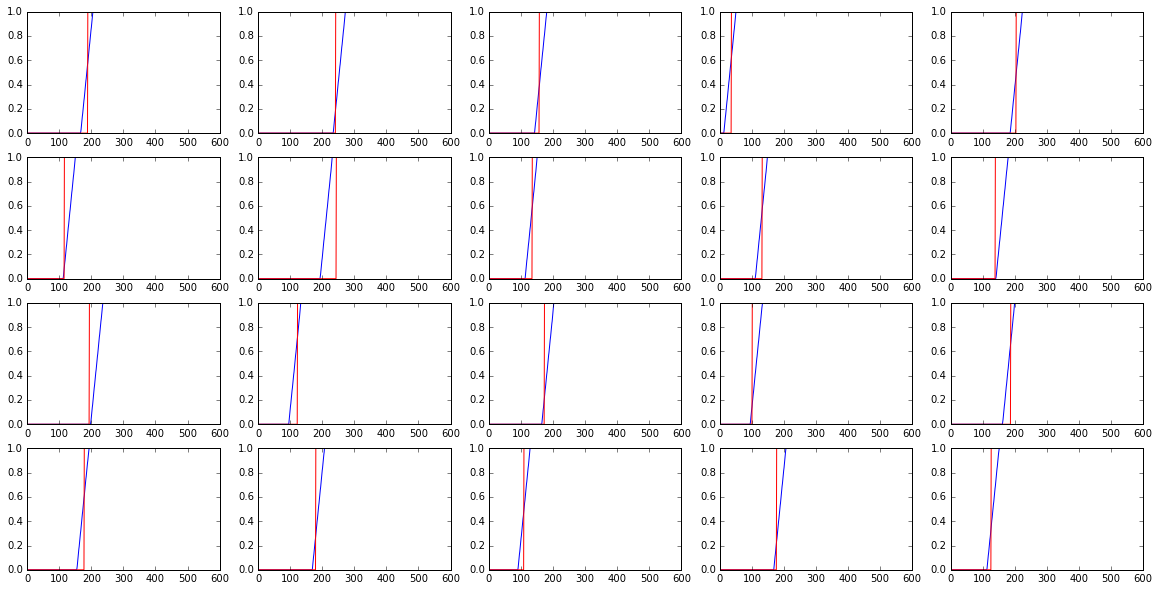

In [123]:
plt.figure(figsize=((20,10)))
display_count = 20
for i, idx in enumerate(random.sample(range(len(volumes_true_ED_dist)), display_count)):
    plt.subplot(display_count//5, 5, i+1)
    plt.plot(np.arange(600), volumes_pred_ED_dists[33][idx], 'b')
    plt.plot(np.arange(600), volumes_true_ED_dist[idx], 'r')

In [ ]:
volumes_pred_ES = []
frames_pred_ES = []
volumes_true_ES = []
volumes_true_ES_dist = []

for pt in tqdm(range(1, 501)):
        
    filepaths = filepaths_train[pt]
    frame_volumes_pred = []
    for frame in range(5,25):
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0
        percentage_factors[1] = 0
        percentage_factors[-1] = 0
        optimal_thresh = get_optimal_thresh_ES(img_stack)
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    min_frame = np.argmin(frame_volumes_pred)
    frames_pred_ES.append(list(range(5,25))[min_frame])
    volumes_pred_ES.append(frame_volumes_pred[min_frame])
    volumes_true_ES.append(systole_labels[pt])
    volumes_true_ES_dist.append(create_label(pt, mode='ES'))
print(pt, end='...done.\n')

print('[ES] MAE: ', np.mean(np.abs(np.array(volumes_pred_ES) - np.array(volumes_true_ES))))

500...done.
[ES] MAE:  7.93996899399


In [ ]:
volumes_pred_ES = []
frames_pred_ES = []
volumes_true_ES = []
volumes_true_ES_dist = []

for pt in tqdm(range(1, 501)):
        
    filepaths = filepaths_train[pt]
    frame_volumes_pred = []
    for frame in range(5,25):
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0
        percentage_factors[1] = 0.1
        percentage_factors[-1] = 0
        optimal_thresh = get_optimal_thresh_ES(img_stack)
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    min_frame = np.argmin(frame_volumes_pred)
    frames_pred_ES.append(list(range(5,25))[min_frame])
    volumes_pred_ES.append(frame_volumes_pred[min_frame])
    volumes_true_ES.append(systole_labels[pt])
    volumes_true_ES_dist.append(create_label(pt, mode='ES'))
print(pt, end='...done.\n')

print('[ES] MAE: ', np.mean(np.abs(np.array(volumes_pred_ES) - np.array(volumes_true_ES))))

500...done.
[ES] MAE:  7.85939909621


In [ ]:
volumes_pred_ES = []
frames_pred_ES = []
volumes_true_ES = []
volumes_true_ES_dist = []

for pt in tqdm(range(1, 501)):
        
    filepaths = filepaths_train[pt]
    frame_volumes_pred = []
    for frame in range(5,25):
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0
        percentage_factors[1] = 0.25
        percentage_factors[-1] = 0
        optimal_thresh = get_optimal_thresh_ES(img_stack)
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    min_frame = np.argmin(frame_volumes_pred)
    frames_pred_ES.append(list(range(5,25))[min_frame])
    volumes_pred_ES.append(frame_volumes_pred[min_frame])
    volumes_true_ES.append(systole_labels[pt])
    volumes_true_ES_dist.append(create_label(pt, mode='ES'))
print(pt, end='...done.\n')

print('[ES] MAE: ', np.mean(np.abs(np.array(volumes_pred_ES) - np.array(volumes_true_ES))))

500...done.
[ES] MAE:  8.00837692578


In [133]:
volumes_pred_ES_dists = []
for conf_width in range(5, 80):
    volumes_pred_ES_dists.append([create_distribution([vol + conf_width*(i-50)/100.0 for i in range(101)], 
                                                      [i/100.0 for i in range(101)]) 
                                  for vol in volumes_pred_ES])

CRPS_values_ES = [np.mean(np.square(np.array(dist) - np.array(volumes_true_ES_dist))) for dist in volumes_pred_ES_dists]
best_idx_ES = np.argmin(CRPS_values_ES)
CRPS_ES = CRPS_values_ES[best_idx_ES]
best_conf_width_ES = list(range(5, 80))[best_idx_ES]

print('[ES] CRPS: {} (conf width {})'.format(CRPS_ES, best_conf_width_ES))

[ES] CRPS: 0.010423173 (conf width 28)


- without optimal thresholding: [ES] MAE:  10.8884840384 [ES] CRPS:  0.013049922
- with optimal thresholding: [ES] MAE:  7.9335184535 [ES] CRPS: 0.0101692037 (conf width 28)
- with optimal thresholding and random local jitter (10): [ES] MAE:  8.12593415001 [ES] CRPS: 0.010423173 (conf width 28)

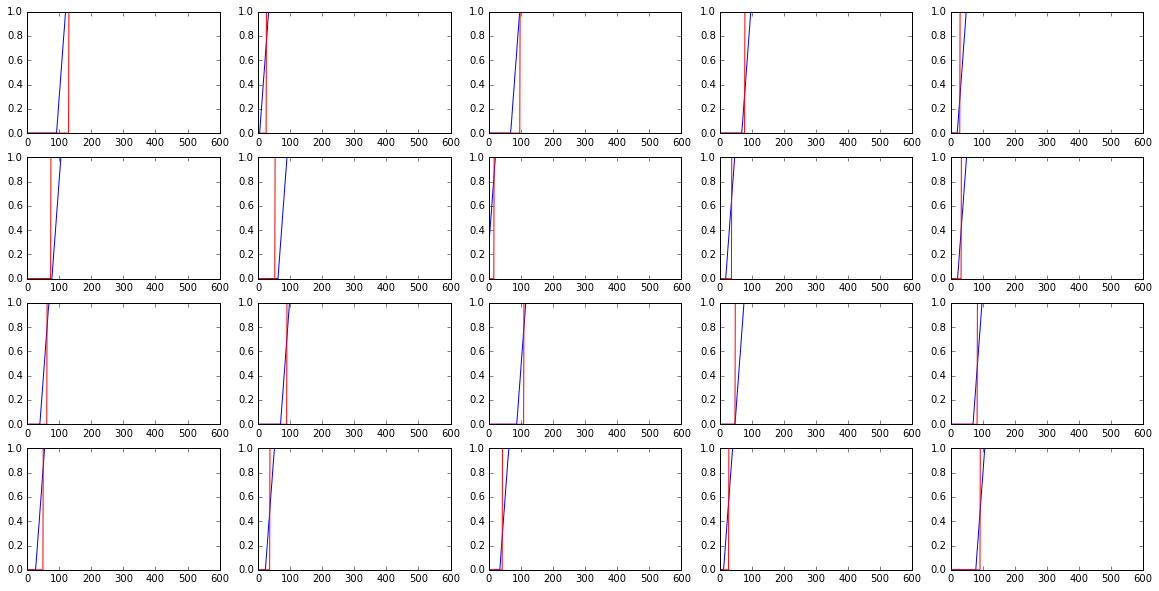

In [128]:
plt.figure(figsize=((20,10)))
display_count = 20
for i, idx in enumerate(random.sample(range(len(volumes_true_ES_dist)), display_count)):
    plt.subplot(display_count//5, 5, i+1)
    plt.plot(np.arange(600), volumes_pred_ES_dists[23][i], 'b')
    plt.plot(np.arange(600), volumes_true_ES_dist[i], 'r')

### validation set prediction

In [17]:
val_volumes_pred_ED = []
val_frames_pred_ED = []

for pt in tqdm(range(501, 701)):
    
    filepaths = filepaths_val[pt]
    frame_volumes_pred = []
    for frame in [28, 29, 0, 1, 2]:
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0.1
        optimal_thresh = get_optimal_thresh_ED(img_stack + [np.zeros((96, 96))] * (20 - len(img_stack)))
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    max_frame = np.argmax(frame_volumes_pred)
    val_frames_pred_ED.append([28, 29, 0, 1, 2][max_frame])
    val_volumes_pred_ED.append(frame_volumes_pred[max_frame])
print(pt, end='...done.\n')

700...done.


In [18]:
val_volumes_pred_ES = []
val_frames_pred_ES = []

for pt in tqdm(range(501, 701)):
        
    filepaths = filepaths_val[pt]
    frame_volumes_pred = []
    for frame in range(5,25):
        vol3d_MIP, vol3d_mask_MIP, orig_shape, pixel_spacing = \
            create_MIP(filepaths, full_size=256, frame=frame)
        centroid = get_MIP_centroid(vol3d_mask_MIP)
        img_stack, img_stack_masks, z_depths, orig_shape, pixel_spacing = \
            create_localized_image_stack(filepaths, centroid, full_size=256, local_size=96, frame=frame)
        percentage_factors = [1]*len(img_stack)
        percentage_factors[0] = 0
        percentage_factors[1] = 0.1
        percentage_factors[-1] = 0
        optimal_thresh = get_optimal_thresh_ES(img_stack + [np.zeros((96, 96))] * (20 - len(img_stack)))
        volume = calculate_volume(img_stack_masks, optimal_thresh, percentage_factors,
                                  z_depths, pixel_spacing, orig_shape)
        frame_volumes_pred.append(volume)

    min_frame = np.argmin(frame_volumes_pred)
    val_frames_pred_ES.append(list(range(5,25))[min_frame])
    val_volumes_pred_ES.append(frame_volumes_pred[min_frame])
print(pt, end='...done.\n')

700...done.


### submission

In [20]:
val_pt_indices = dict([(pt,i) for i,pt in enumerate(range(501, 701))])

val_volumes_pred_ED_dist = [create_distribution([vol + 25*(i-50)/100.0 for i in range(101)], 
                                                [i/100.0 for i in range(101)]) 
                            for vol in val_volumes_pred_ED]

val_volumes_pred_ES_dist = [create_distribution([vol + 15*(i-50)/100.0 for i in range(101)], 
                                                [i/100.0 for i in range(101)]) 
                            for vol in val_volumes_pred_ES]

with open('../../data/sample_submission_validate.csv', 'r') as fi:
    reader = csv.reader(fi)
    header = next(reader)
    
    with open('../../submissions/6-1.csv', 'w') as fo:
        writer = csv.writer(fo, lineterminator='\n')
        writer.writerow(header)
        for rowin in tqdm(reader):
            _id = rowin[0]
            pt, mode = _id.split('_')
            rowout = [_id]
            idx = val_pt_indices[int(pt)]
            if mode.lower() == 'systole':
                rowout.extend(val_volumes_pred_ES_dist[idx].tolist())
            elif mode.lower() == 'diastole':
                rowout.extend(val_volumes_pred_ED_dist[idx].tolist())
            else:
                raise
            writer.writerow(rowout)